In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshmahee","key":"43f2213a6e91296bdd9c20808afed440"}'}

In [2]:
import os
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d wenchik/gender-labelled-panoramic-dental-xray

Dataset URL: https://www.kaggle.com/datasets/wenchik/gender-labelled-panoramic-dental-xray
License(s): MIT
  0% 0.00/111M [00:00<?, ?B/s]
100% 111M/111M [00:00<00:00, 1.33GB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gender-labelled-panoramic-dental-xray.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow import keras
from keras import models,layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization,GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [7]:
batch_size = 32
img_size = (224,224)

In [8]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    fill_mode = 'nearest',
    brightness_range = [0.8,1.2]
)
val_gen = ImageDataGenerator(
    rescale = 1./255
)

In [9]:
train_df = train_gen.flow_from_directory(
    '/content/Radiographs/train',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True
)
val_df = val_gen.flow_from_directory(
    '/content/Radiographs/val',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False
)
test_df = val_gen.flow_from_directory(
    '/content/Radiographs/test',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False
)

Found 686 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [14]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
model.compile(Adam(learning_rate= 0.0001), loss= 'binary_crossentropy', metrics= ['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_df,epochs=100,validation_data=val_df,
                  callbacks=[early_stopping])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5090 - loss: 0.8358 - val_accuracy: 0.5000 - val_loss: 0.7108
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 723ms/step - accuracy: 0.5002 - loss: 0.7727 - val_accuracy: 0.5000 - val_loss: 0.6801
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 681ms/step - accuracy: 0.5182 - loss: 0.7435 - val_accuracy: 0.5000 - val_loss: 0.6734
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 685ms/step - accuracy: 0.5089 - loss: 0.7544 - val_accuracy: 0.6429 - val_loss: 0.6585
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 681ms/step - accuracy: 0.5633 - loss: 0.6946 - val_accuracy: 0.5204 - val_loss: 0.6572
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 735ms/step - accuracy: 0.5062 - loss: 0.7302 - val_accuracy: 0.5153 - val_loss: 0.6552
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 680ms/step - accuracy: 0.5696 - loss: 0.6810 - val_accuracy: 0.6173 - val_loss: 0.6439
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 681ms/step - accuracy: 0.5310 - loss: 0.7082 - val

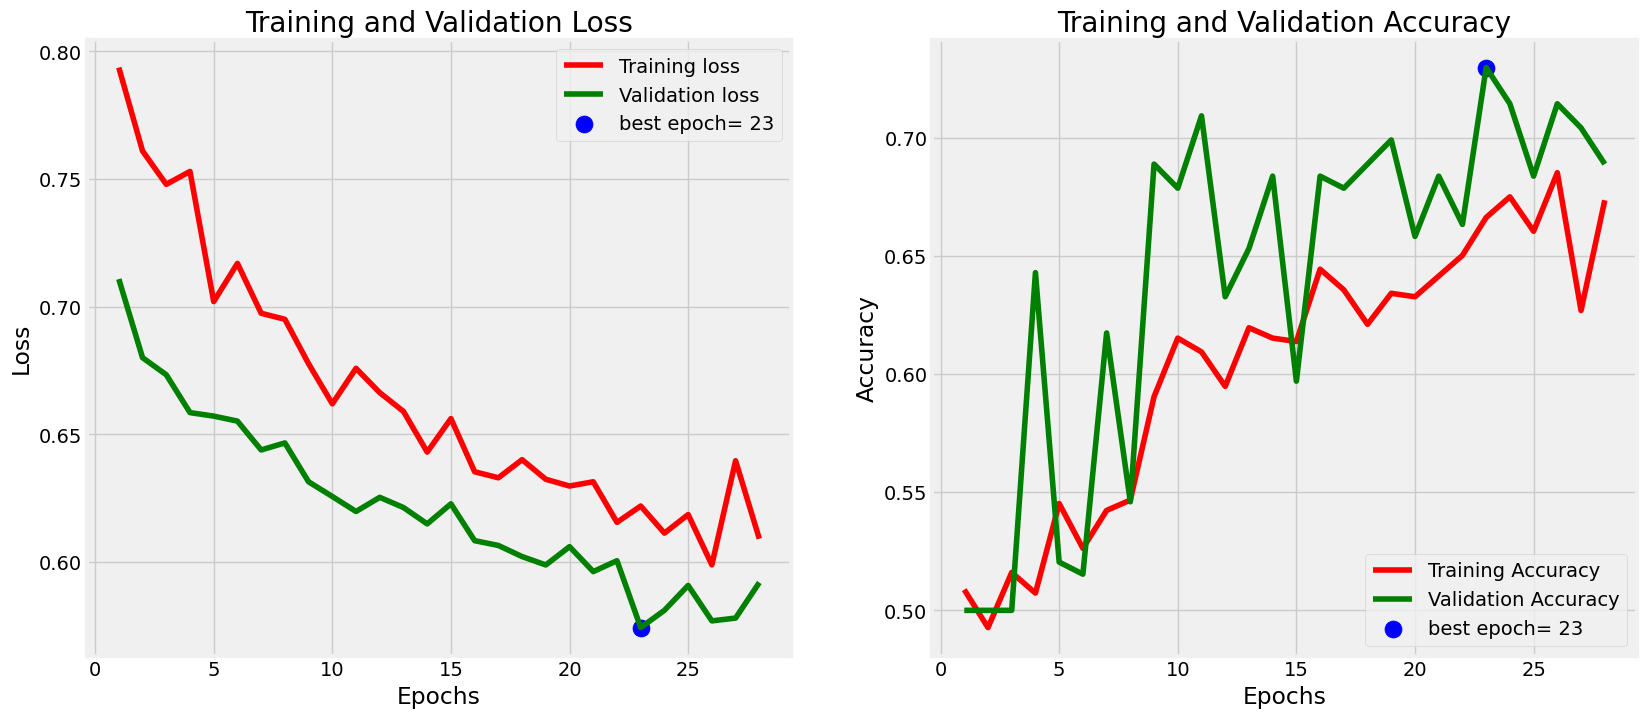

In [18]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [19]:
y_pred_probs = model.predict(test_df)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_df.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [25]:
from sklearn.metrics import accuracy_score

In [26]:
accuracy_score(y_true, y_pred)

0.711340206185567

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_df.class_indices))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)
print(cm)

Classification Report:

              precision    recall  f1-score   support

      female       0.84      0.53      0.65        49
        male       0.65      0.90      0.75        48

    accuracy                           0.71        97
   macro avg       0.75      0.71      0.70        97
weighted avg       0.75      0.71      0.70        97


Confusion Matrix:

[[26 23]
 [ 5 43]]


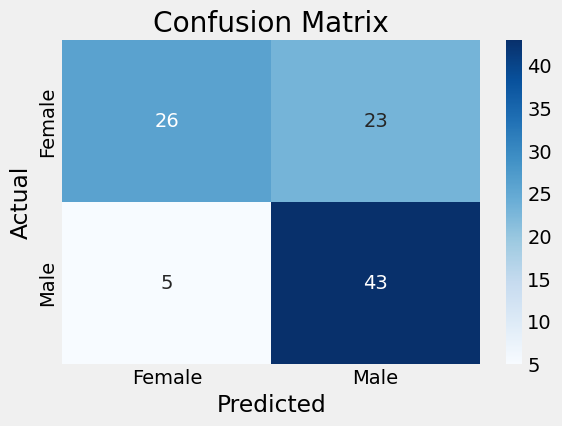

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


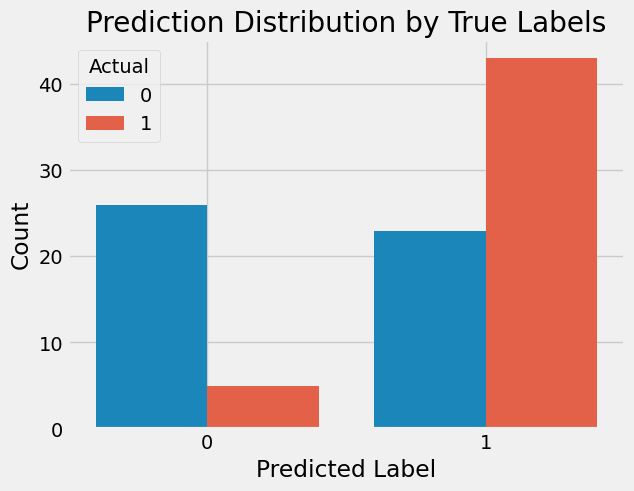

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_pred, hue=y_true)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Prediction Distribution by True Labels")
plt.legend(title="Actual")
plt.grid(True)
plt.show()

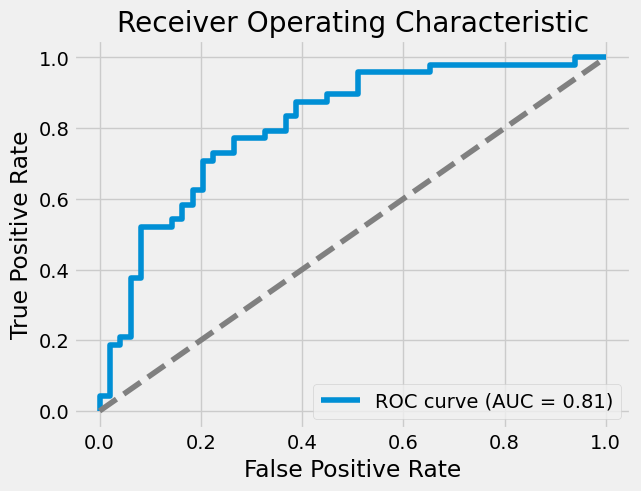

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)  # y_pred_prob: probability from model.predict()
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
model.save("ResNet_Gender_predictor.h5")

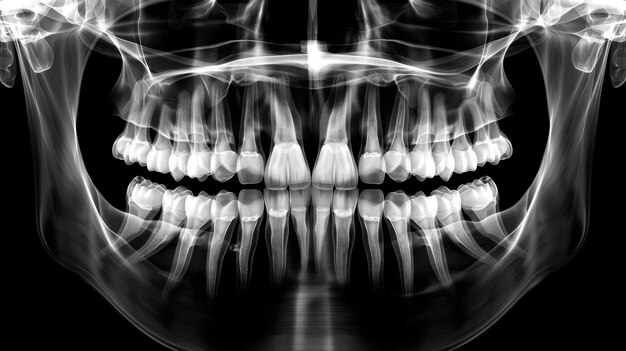

In [33]:
Image.open('/content/detailed-dental-radiography-image-showing-full-set-teeth-jaw-structure-providing-clear-visual-information-dental-diagnostics-treatment-planning-with-modern-radiographic-equipment_1282204-3384.jpg')

In [36]:
img_path = '/content/detailed-dental-radiography-image-showing-full-set-teeth-jaw-structure-providing-clear-visual-information-dental-diagnostics-treatment-planning-with-modern-radiographic-equipment_1282204-3384.jpg'

In [37]:
img = cv2.imread(img_path)

In [41]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [42]:
img_resized = cv2.resize(img_rgb, (224, 224))

In [43]:
img_normalized = img_resized.astype(np.float32) / 255.0

In [44]:
class_names = ['female', 'male']

In [47]:
img_array = np.expand_dims(img_normalized, axis=0)
pred = model.predict(img_array)[0][0]
pred_class = "Male" if pred > 0.5 else "Female"
print(f"Prediction: {pred_class} ({pred:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: Male (0.95)


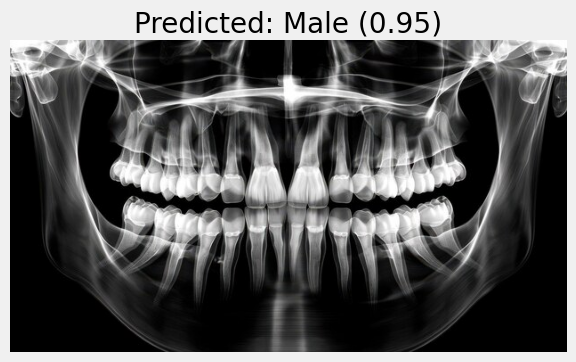

In [48]:
plt.imshow(img_rgb)
plt.title(f"Predicted: {pred_class} ({pred:.2f})")
plt.axis("off")
plt.show()